In [10]:
from langgraph.graph import StateGraph, MessagesState, START
from IPython.display import Image, display
from langgraph.types import Command
from typing import Literal

In [28]:
class AgentState(MessagesState):
    message: str
    processed_data: str | None = None  # 可选字段，用于存储中间结果

# 定义两个可路由的节点
def node_a(state: AgentState):
    print("✅ directed to node_a")
    return Command(
        update={"message": "This is node_a"}
    )


def node_b(state: AgentState):
    print("✅ directed to node_b")
    return Command(
        update={"message": "This is node_b"}
    )

# 定义路由判断逻辑
def decide_next_node(state: AgentState) -> Literal["node_a", "node_b"]:
    """
    根据 message 的内容决定下一个节点。
    """
    if "a" in state.get("message").lower():
        return "node_a"
    else:
        return "node_b"

# 定义路由节点（核心）
def my_node(state: AgentState) -> Command[Literal["node_a", "node_b"]]:
    """
    根据当前状态决定跳转到 node_a 或 node_b。
    """
    next_node_name = decide_next_node(state)
    result_data = f"Processed: {state.get("message")}"

    return Command(
        update={"processed_data": result_data},
        goto=next_node_name
    )

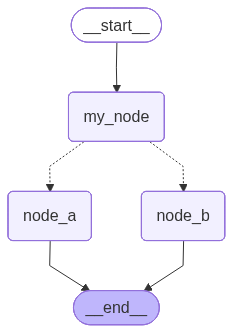


--- 测试输入：包含 'a' ---
✅ directed to node_a
结果： {'messages': [], 'message': 'This is node_a', 'processed_data': 'Processed: apple'}

--- 测试输入：不包含 'a' ---
✅ directed to node_b
结果： {'messages': [], 'message': 'This is node_b', 'processed_data': 'Processed: hello world'}


In [29]:
# ===== 构建 LangGraph =====
def build_graph():
    graph = StateGraph(AgentState)

    # 添加节点
    graph.add_node("my_node", my_node)
    graph.add_node("node_a", node_a)
    graph.add_node("node_b", node_b)

    # 设置入口节点
    graph.add_edge(START, "my_node")

    # 构建编译图
    return graph.compile()


# ===== 运行示例 =====
if __name__ == "__main__":
    app = build_graph()
    display(Image(app.get_graph().draw_mermaid_png()))

    # 输入1：含有 "a" → 路由到 node_a
    print("\n--- 测试输入：包含 'a' ---")
    result = app.invoke(AgentState(message="apple"))
    print("结果：", result)

    # 输入2：不含 "a" → 路由到 node_b
    print("\n--- 测试输入：不包含 'a' ---")
    result = app.invoke(AgentState(message="hello world"))
    print("结果：", result)